# Graph neighborhood density estimator for spatial coordinates

## Sasha Safonova
## September 2021

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

from sklearn.neighbors import NearestNeighbors


In [2]:
def L(A, normalized=True):
    """L: compute a graph laplacian

    Args:
        A (N x N np.ndarray): Adjacency matrix of graph
        normalized (bool, optional): Normalized or combinatorial Laplacian

    Returns:
        L (N x N np.ndarray): graph Laplacian
    """
    # L^c = D - A, where A is the adjacency matrix and D is the degree matrix:
    # D = diag(d(i)); d(i) =\Sum^N_{j=1} A_{ij}

    # Compute the diagonal normalization matrix Dnorm from the adjacency matrix
    # As the sum of the row values in adjacency matrix A across the diagonal
    D = np.zeros((len(A), len(A)))
    for ii, row in enumerate(A):
        D[ii][ii] = np.sum(row)
    # compute the combinatorial graph Laplacian
    L_c = D - A

    if normalized:
        # normalize the Laplacian as
        # L_s = D^-1/2 A D^-1/2
        sqrtDnorm = np.sqrt(D)
        inverse_sqrtDnorm = np.linalg.inv(sqrtDnorm)
        L_s_step_one = inverse_sqrtDnorm @ L_c
        L_s = L_s_step_one @ inverse_sqrtDnorm
        L = L_s
    else:
        L = L_c
    return L


def compute_fourier_basis(L, class_version=True):
    """compute_fourier_basis: Laplacian Diagonalization

    Args:
        L (N x N np.ndarray): graph Laplacian

    Returns:
        e (N x 1 np.ndarray): graph Laplacian eigenvalues
        psi (N x N np.ndarray): graph Laplacian eigenvectors
    """
    e, psi = eigh(L)

    #Sort the eigenvalues from 0 to 1
    lambda_ordering = np.argsort(e)
    e = e[lambda_ordering]
    psi = psi[lambda_ordering]
    if class_version:
        return e, psi
    else:
        return e, psi, lambda_ordering


def filterbank_matrix(psi, e, h, c=0.05):
    """filterbank_matrix: build a filter matrix using the input filter h

    Args:
        psi (N x N np.ndarray): graph Laplacian eigenvectors
        e (N x 1 np.ndarray): graph Laplacian eigenvalues
        h (function handle): A function that takes in eigenvalues
        and returns values in the interval (0,1)
        c (float): Cutoff value to feed to the filter function

    Returns:
        H (N x N np.ndarray): Filter matrix that can be used in the form
        filtered_s = H@s
    """
    # equation (9): H=\Psi h(\lambda)\Psi^T
    filter_evaluation = np.diag([h(lambda_l, c=c) for lambda_l in e])
    first_part_of_H = psi @ filter_evaluation
    H = first_part_of_H @ psi.T

    return H

def gaussian_noise_filter(eigenvalue, c=0.05):
    if eigenvalue < c:
        return 1
    else:
        return 0
    
def single_eigenvector_filter(eigenvalue, c):
    low_threshold, high_threshold = c
    if (eigenvalue < high_threshold) &(eigenvalue> low_threshold):
            return 1
    else:
        return 0
    
def gaussian_kernel(X, kernel_type="gaussian", sigma=3.0, k=5):
    """gaussian_kernel: Build an adjacency matrix for data using a Gaussian kernel
    Args:
        X (N x d np.ndarray): Input data
        kernel_type: "gaussian" or "adaptive". Controls bandwidth
        sigma (float): Scalar kernel bandwidth
        k (integer): nearest neighbor kernel bandwidth
    Returns:
        W (N x N np.ndarray): Weight/adjacency matrix induced from X
    """
    _g = "gaussian"
    _a = "adaptive"

    kernel_type = kernel_type.lower()
    D = squareform(pdist(X))
    if kernel_type == "gaussian":  # gaussian bandwidth checking
        print("fixed bandwidth specified")
        if type(sigma) is int:
            sigma = float(sigma)
        if not all([type(sigma) is float, sigma > 0]):  # [float, positive]
            print("invalid gaussian bandwidth, using sigma = max(min(D)) as bandwidth")
            D_find = D + np.eye(np.size(D, 1)) * 1e15
            sigma = np.max(np.min(D_find, 1))
            del D_find
        print("sigma is {0}".format(sigma))
        sigma = np.ones(np.size(D, 1)) * sigma
    elif kernel_type == "adaptive":  # adaptive bandwidth
        print("adaptive bandwidth specified")

        # [integer, positive, less than the total samples]
        if not all([type(k) is int, k > 0, k < np.size(D, 1)]):
            print("invalid adaptive bandwidth, using k=5 as bandwidth")
            k = 5

        knnDST = np.sort(D, axis=1)  # sorted neighbor distances
        sigma = knnDST[:, k]  # k-nn neighbor. 0 is self.
        del knnDST
    else:
        raise ValueError

    W = ((D**2) / sigma[:, np.newaxis]**2).T
    W = np.exp(-1 * (W))
    W = (W + W.T) / 2  # symmetrize
    W = W - np.eye(W.shape[0])  # remove the diagonal
    return W


In [5]:
# Load your 3D position data here

x = np.load("")
y = np.load("")
z = np.load("")

coords = np.array([x, y, z]).T  #Assemble the 3D positions 

In [6]:
# Compute the affinity matrix with a gaussian kernel
# The sigma may need to be adjusted depending on how sparse your data is
AG = gaussian_kernel(coords, sigma=10)  # sigma is in the same units as the input coordinates

fixed bandwidth specified
sigma is 10.0


/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


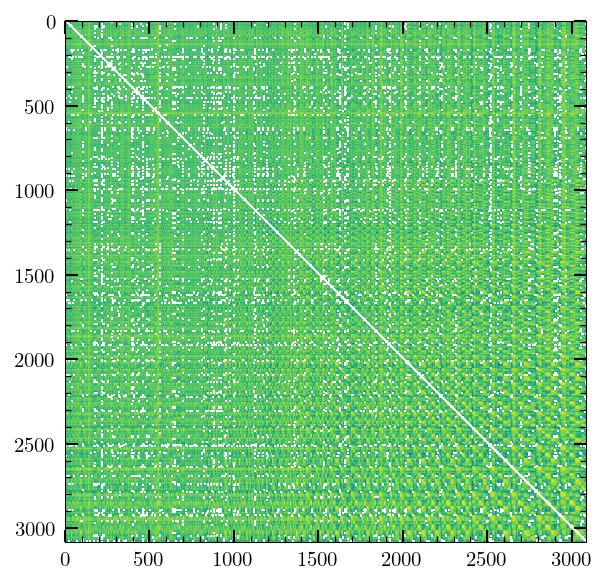

In [7]:
#Look at the affinity matrix
fig, axes = plt.subplots(dpi=150)
axes.imshow(np.log10(AG));

In [8]:
# Compute a normalized graph Laplacian
LapAG = L(AG)

# Eigendecompose the graph laplacian
Laplacian_eigenvalues, Laplacian_eigenvectors, eigen_ordering = compute_fourier_basis(LapAG, class_version=False)

In [9]:
# Look at the eigenvalues of the graph laplacian
Laplacian_eigenvalues

array([1.94504785e-16, 1.12081122e-03, 1.68266990e-03, ...,
       1.93403195e+00, 1.93975442e+00, 1.95084940e+00])

In [10]:
c = 1.12e-03 #Set filter's cutoff to the second lowest eigenvalue, so that we only keep the smallest eigenvalue

In [11]:
# Compute filter that keeps eigenvector with lowest eigenvalue
H = filterbank_matrix(Laplacian_eigenvectors, Laplacian_eigenvalues, gaussian_noise_filter, c=c)

#Multiply filter by eigenvalues to get neighborhood density
neighborhood_density = H @ Laplacian_eigenvalues

Text(0, 0.5, 'Neighborhood density')

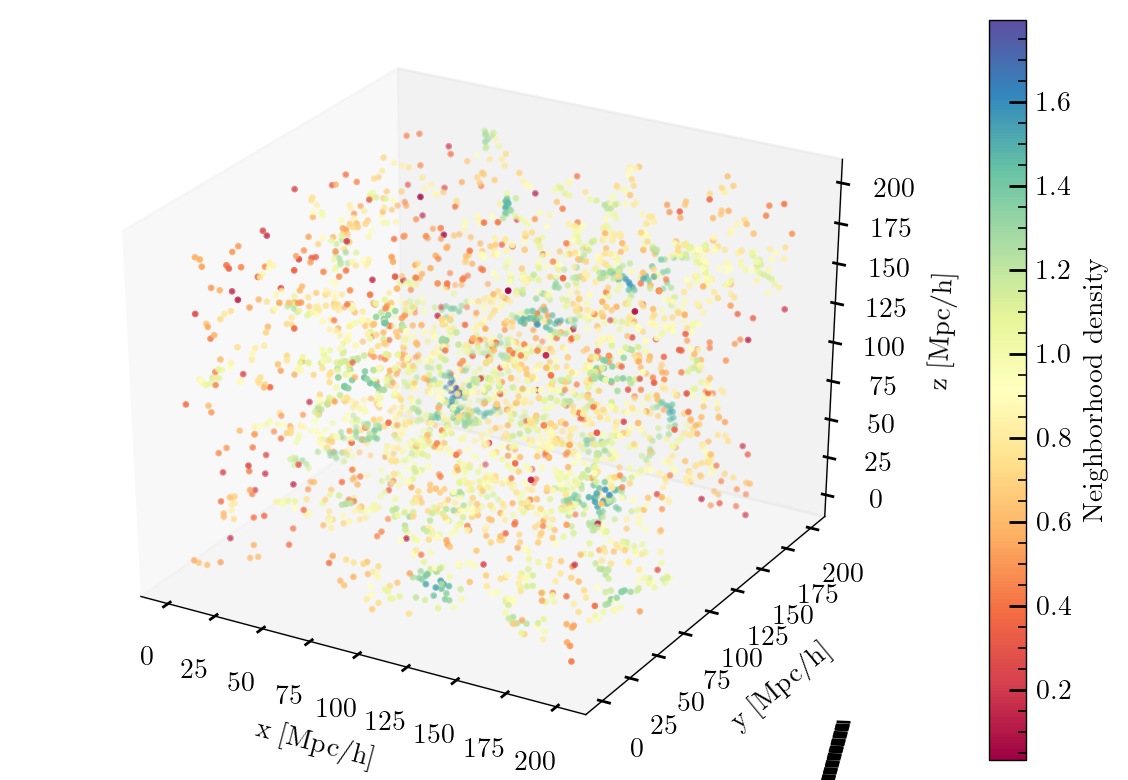

In [13]:
# Look at neighborhood density painted onto data point coordinates
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
scat = ax.scatter(x, 
                  y, 
                  z,
                  c=neighborhood_density, s=2, cmap='Spectral')
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', zlabel='z [Mpc/h]')
cbar = plt.colorbar(scat)
cbar.ax.set_ylabel("Neighborhood density")